# May 24th, 2022 (new results w/ bp: 192 * 3, k = 7)

**Motivation**: slow band is maximally similar <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(data, vmin=0.1, vmax=None, figsize=None, cmap='magma'):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (12.8, 1.25 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=True,
        reshape=True,
    )
 
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=13)
    remove_ticks(axes)
    plt.show()

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice((192, 3))

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

### K = 7 p = 25

In [5]:
task = 'rest'
band_ca = (0.01, 0.5)
mice.setup_func_data(task, band_ca=band_ca)

num_k, p = 7, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

### First show this

In [6]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

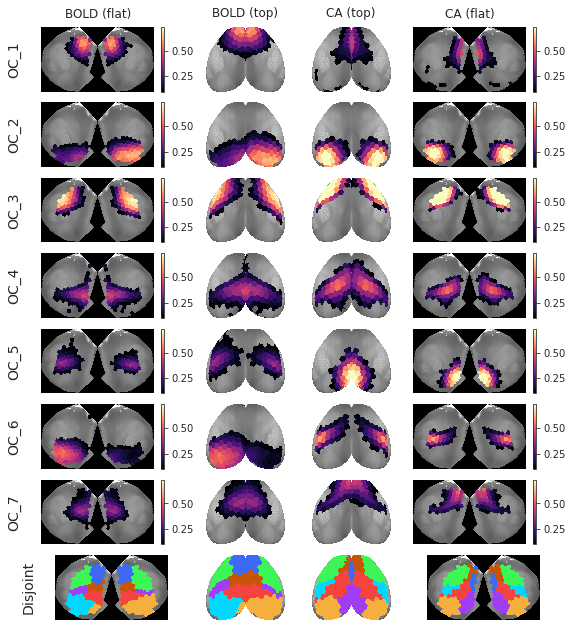

In [7]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

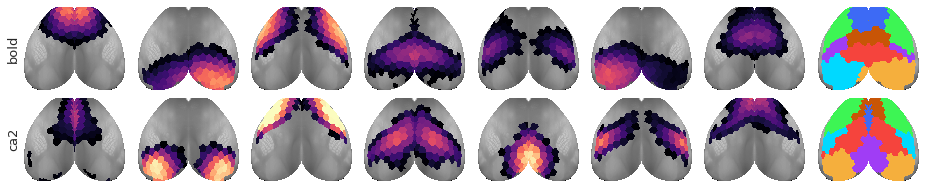

In [8]:
d2p = {
    'bold': gr_bo.trim2d(proj_bo),
    'ca2': gr_ca.trim2d(proj_ca),
}
quick_show(d2p, vmin=0.1, vmax=0.8)

In [10]:
thres = 0.25

props_bo['num_k'] = num_k + 1
_gr_bo = Group(**props_bo).fit_group()
_ = _gr_bo._merge_bold(thres)
d2p['bold+1'] = _gr_bo.trim2d(_gr_bo.project_vec())

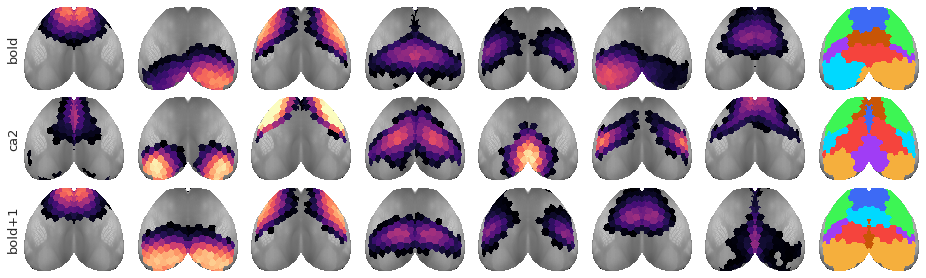

In [11]:
quick_show(d2p, vmin=0.1, vmax=0.8)

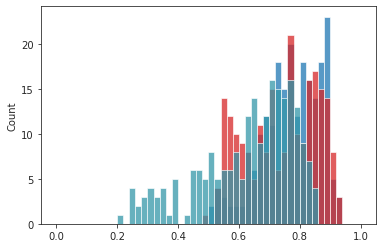

In [13]:
h_true = sp_stats.entropy(gr_bo.pi, axis=-2) / np.log(7)
h_fab = sp_stats.entropy(_gr_bo.pi, axis=-2) / np.log(7)
h_ca = sp_stats.entropy(gr_ca.pi, axis=-2) / np.log(7)

sns.histplot(h_true, bins=np.linspace(0, 1, 51))
sns.histplot(h_fab, bins=np.linspace(0, 1, 51), color='C3')
sns.histplot(h_ca, bins=np.linspace(0, 1, 51), color=pal['ca2']);

In [14]:
h = np.concatenate([
    h_true.reshape(1, -1),
    h_fab.reshape(1, -1)
])
tr_h = _gr_bo.project_vec(h)
tr_h = _gr_bo.trim2d(tr_h)

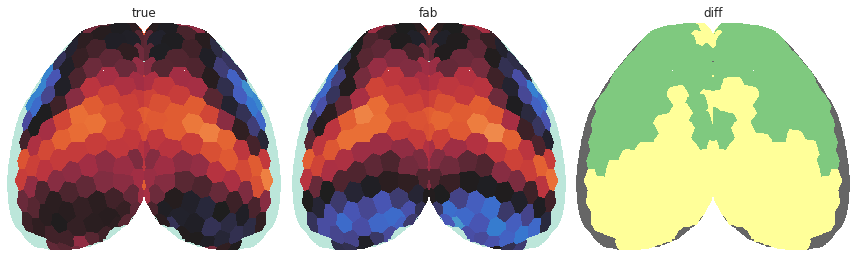

In [15]:
fig, axes = create_figure(1, 3, (12, 4))
axes[0].imshow(mwh(tr_h['top'] == 0, tr_h['proj-top'][0]), vmin=0.4, vmax=1.0, cmap='icefire')
axes[1].imshow(mwh(tr_h['top'] == 0, tr_h['proj-top'][1]), vmin=0.4, vmax=1.0, cmap='icefire')
axes[2].imshow(mwh(tr_h['top'] == 0, tr_h['proj-top'][2]), cmap='Accent_r')
axes[0].set_title('true')
axes[1].set_title('fab')
axes[2].set_title('diff')
remove_ticks(axes)
plt.show()

In [16]:
tr_h_ca = gr_ca.project_vec(h_ca, add_disjoint=False)
tr_h_ca = gr_ca.trim2d(tr_h_ca)

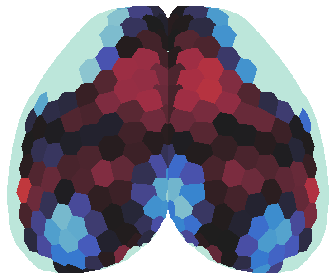

In [17]:
fig, ax = create_figure()
ax.imshow(mwh(tr_h_ca['top'] == 0, tr_h_ca['proj-top'][0]), vmin=0.4, vmax=1.0, cmap='icefire')
remove_ticks(ax)

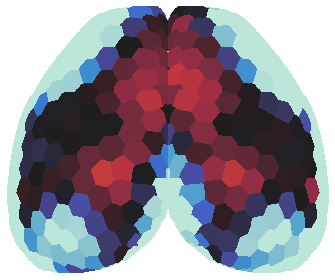

In [18]:
h_run_bo_true = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(7)
h_run_bo_fab = sp_stats.entropy(_gr_bo.run_pi, axis=-2) / np.log(7)
h_run_ca = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(7)

<AxesSubplot:ylabel='Count'>

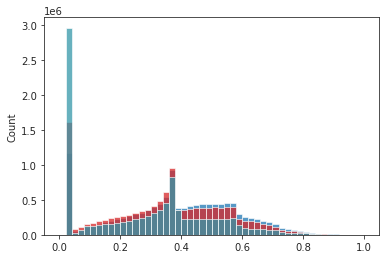

In [19]:
sns.histplot(h_run_bo_true[h_run_bo_true.nonzero()], bins=np.linspace(0, 1, 51))
sns.histplot(h_run_bo_fab[h_run_bo_fab.nonzero()], bins=np.linspace(0, 1, 51), color='C3')
sns.histplot(h_run_ca[h_run_ca.nonzero()], bins=np.linspace(0, 1, 51), color=pal['ca2'])

<AxesSubplot:ylabel='Count'>

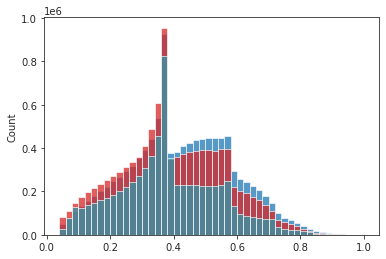

In [25]:
sns.histplot(h_run_bo_true[h_run_bo_true.nonzero()], bins=np.linspace(2/50, 1, 49))
sns.histplot(h_run_bo_fab[h_run_bo_fab.nonzero()], bins=np.linspace(2/50, 1, 49), color='C3')
sns.histplot(h_run_ca[h_run_ca.nonzero()], bins=np.linspace(2/50, 1, 49), color=pal['ca2'])

In [26]:
h_anim_bo_true = bn.nanmean(bn.nanmean(bn.nanmean(h_run_bo_true, 3), 2), 1)
h_anim_bo_fab = bn.nanmean(bn.nanmean(bn.nanmean(h_run_bo_fab, 3), 2), 1)
h_anim_ca = bn.nanmean(bn.nanmean(bn.nanmean(h_run_ca, 3), 2), 1)

<AxesSubplot:ylabel='Count'>

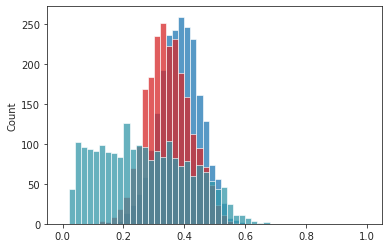

In [27]:
sns.histplot(h_anim_bo_true[h_anim_bo_true.nonzero()], bins=np.linspace(0, 1, 51))
sns.histplot(h_anim_bo_fab[h_anim_bo_fab.nonzero()], bins=np.linspace(0, 1, 51), color='C3')
sns.histplot(h_anim_ca[h_anim_ca.nonzero()], bins=np.linspace(0, 1, 51), color=pal['ca2'])

In [28]:
h_avg_bo_true = bn.nanmean(h_anim_bo_true, 0)
h_avg_bo_fab = bn.nanmean(h_anim_bo_fab, 0)
h_avg_ca = bn.nanmean(h_anim_ca, 0)

<AxesSubplot:ylabel='Count'>

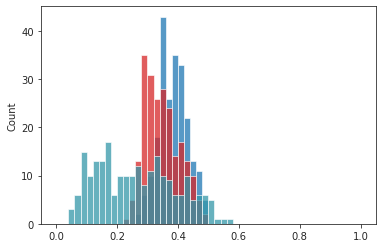

In [29]:
sns.histplot(h_avg_bo_true[h_avg_bo_true.nonzero()], bins=np.linspace(0, 1, 51))
sns.histplot(h_avg_bo_fab[h_avg_bo_fab.nonzero()], bins=np.linspace(0, 1, 51), color='C3')
sns.histplot(h_avg_ca[h_avg_ca.nonzero()], bins=np.linspace(0, 1, 51), color=pal['ca2'])

In [30]:
h = np.concatenate([
    h_avg_bo_true.reshape(1, -1),
    h_avg_bo_fab.reshape(1, -1),
    h_avg_ca.reshape(1, -1),
])
tr_h = gr_ca.project_vec(h)
tr_h = gr_ca.trim2d(tr_h)

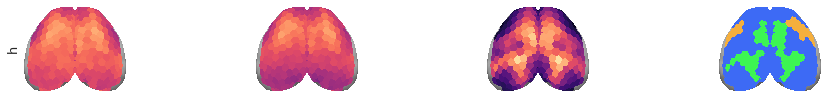

In [31]:
quick_show({'h': tr_h}, vmin=0.01, vmax=0.6)

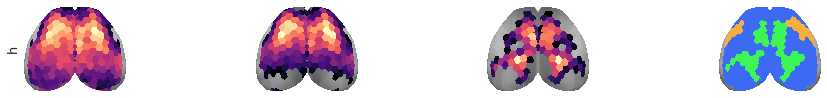

In [35]:
quick_show({'h': tr_h}, vmin=0.3)

## Show all bands

In [36]:
task = 'rest'

num_k, p = 7, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [37]:
d2p = {}

# bold
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
_ = gr_bo._merge_bold(0.25)
d2p['bold'] = gr_bo.trim2d(gr_bo.project_vec())

# ca2
pi_ca = {}
for b in [(0.01, 0.50), 0.5, 0.01]:
    mice.setup_func_data(task, band_ca=b)
    gr_ca = Group(**props_ca).fit_group()
    gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())
    pi_ca[b] = gr_ca.pi

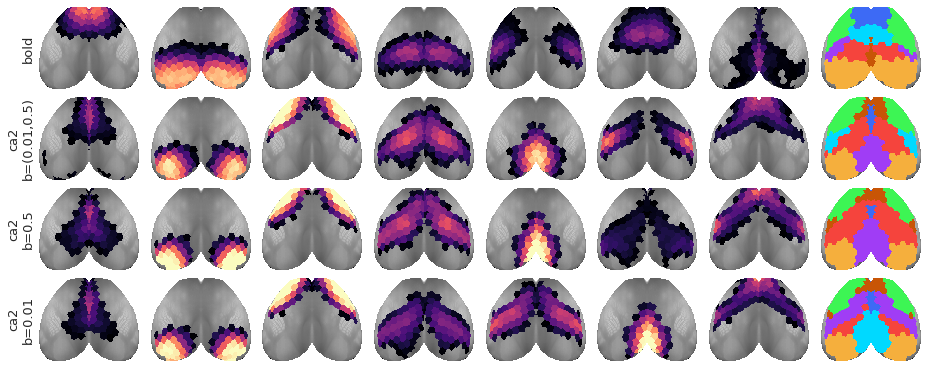

In [38]:
quick_show(d2p, vmin=0.10, vmax=0.8)

In [46]:
mappings = find_best_mappings(gr_bo.pi, pi_ca)
for b, gmap in mappings.items():
    new_ids = list(gmap.values())
    if b == 0.5:
        i, j = new_ids[3], new_ids[4]
        new_ids[3], new_ids[4] = j, i
    pi = pi_ca[b][new_ids]
    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec(pi))

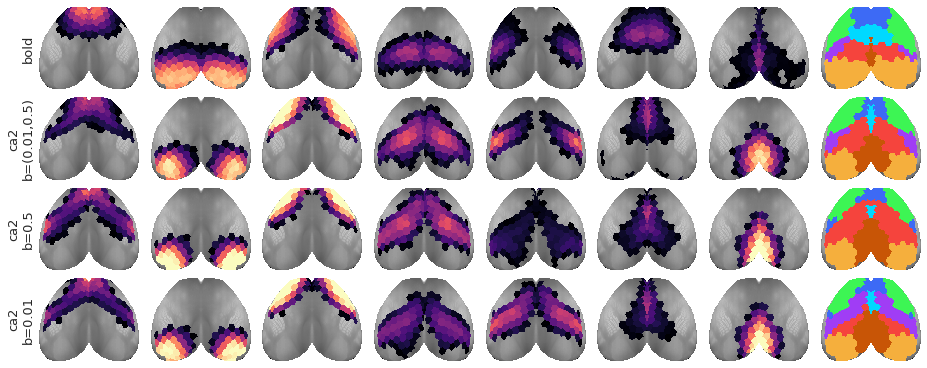

In [48]:
quick_show(d2p, vmin=0.10, vmax=0.8)

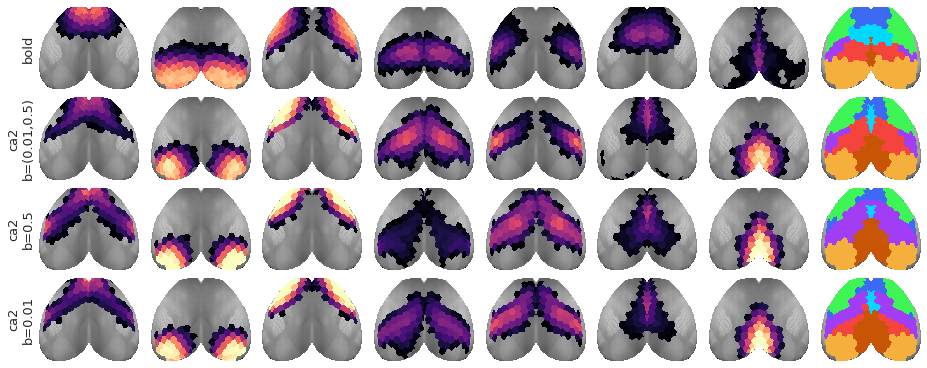

### Different starting k

In [31]:
task = 'rest'

num_k, p = 16, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [32]:
d2p = {}

# bold
# props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
# _ = gr_bo._merge_bold(0.25)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
    gr_bo.run_pi, 3), 2), 1), 0)
d2p['bold'] = gr_bo.trim2d(gr_bo.project_vec())

# ca2
pi_ca = {}
for b in [(0.01, 0.50), 0.5, 0.01]:
    mice.setup_func_data(task, band_ca=b)
    gr_ca = Group(**props_ca).fit_group()
    gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
        gr_ca.run_pi, 3), 2), 1), 0)
    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())
    pi_ca[b] = gr_ca.pi

In [33]:
mappings = find_best_mappings(gr_bo.pi, pi_ca)
for b, gmap in mappings.items():
    pi = pi_ca[b][list(gmap.values())]
    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec(pi))

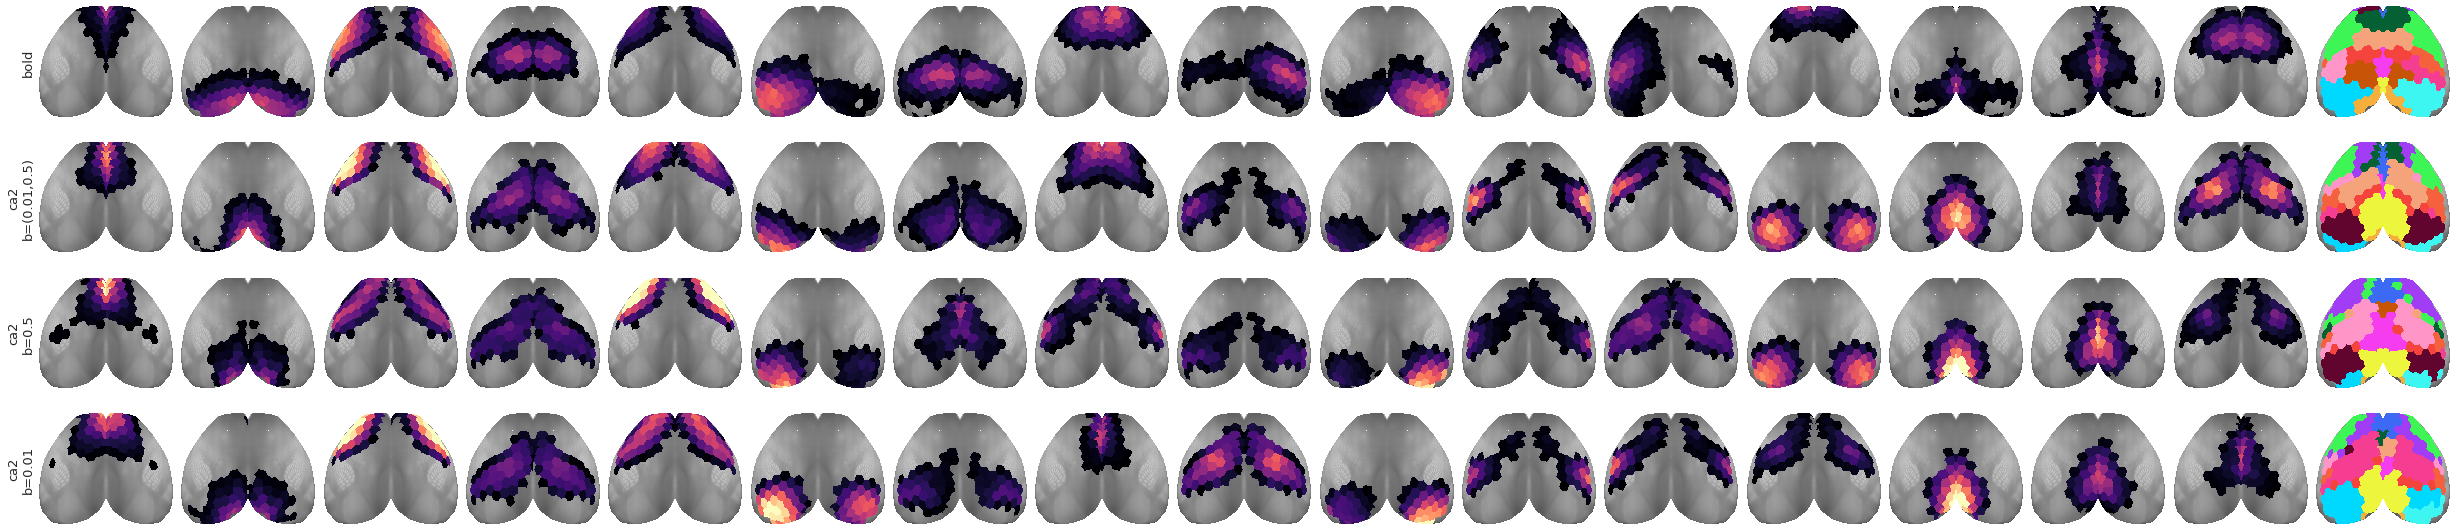

In [39]:
quick_show(d2p, vmin=0.05, vmax=0.6, figsize=(34, 7.5))